<a href="https://colab.research.google.com/github/ashpakshaikh26732/Unet-FCN/blob/main/Unet_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**all packages**

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from IPython.display import display

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print(f'no of tpus : {strategy.num_replicas_in_sync}')
except ValueError :
  print('tpu failed to initilized')

tpu failed to initilized


**mixed precision training**

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

**copy datasets from drive**

In [ ]:
!cp /content/drive/MyDrive/Cityscapes/gtFine_trainvaltest.zip /content/
!cp /content/drive/MyDrive/Cityscapes/leftImg8bit_trainvaltest.zip /content

**extract trainig the data**

In [ ]:
os.system("unzip -q /content/gtFine_trainvaltest.zip -d /content/ ")
os.system("unzip -q /content/leftImg8bit_trainvaltest.zip -d /content/")

In [ ]:
print("Train Images:", len(os.listdir("/content/leftImg8bit/train/aachen")))  # Adjust path as needed
print("Train Labels:", len(os.listdir("/content/gtFine/train/aachen")))

In [ ]:
print("test images : ", len(os.listdir('/content/leftImg8bit/test')))

**Global Valrible**

In [ ]:
img_height = 224
img_width = 224
batch_size = 16
# final_batch_size = batch_size * strategy.num_replicas_in_sync

**loading images and labels from directry**

In [ ]:
def load_img():
    train_dir = '/content/leftImg8bit/train'
    train_image_cities = os.listdir(train_dir)
    train_images = []

    for city in train_image_cities:
        train_city = os.path.join(train_dir, city)
        images = [os.path.join(train_city, img) for img in os.listdir(train_city) if img.endswith('.png')]
        train_images.extend(images)

    return train_images

def load_labels():
    train_dir = '/content/gtFine/train'
    train_labels_cities = os.listdir(train_dir)
    train_labels = []
    for city in train_labels_cities:
        train_city_label = os.path.join(train_dir, city)
        labels = [f for f in os.listdir(train_city_label) if f.endswith('_gtFine_labelIds.png')]
        for label in labels:
            label_path = os.path.join(train_city_label, label)
            train_labels.append(label_path)
    return train_labels

**reading images from path**

In [ ]:
def read_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    img = img / 255.0
    return img

def read_labels(label_path):
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)
    label = tf.image.resize(label, (img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(label, tf.uint8)


**augmentation**

In [ ]:
def augment(image, label):

    label = tf.cast(label, tf.float32)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    image = tf.image.random_brightness(image, max_delta=0.1)

    combined = tf.concat([image, label], axis=-1)
    combined = tf.image.random_crop(combined, size=[224, 224, 6])

    image, label = tf.split(combined, num_or_size_splits=2, axis=-1)


    label = tf.cast(label, tf.uint8)

    return image, label


**creating dataset**

In [ ]:
images = load_img()
labels = load_labels()
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.map(lambda image_path , label_path :( read_img(image_path) , label_path)).map(lambda image , label_path : (image,read_labels(label_path=label_path)))
dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).cache().batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# for image , label in dataset.take(1):
#   print(f'image shape : {image.shape} , label shape {label.shape}')
#   print(f'image datatype : {image.dtype}, label dtype {label.dtype}')

**FCN model**

In [ ]:
class Block(tf.keras.models.Model):
    def __init__(self, n_conv, filters, kernel_size, activation, pool_size, pool_stride, block_name):
        super().__init__()
        self.conv_layers = [
            tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same',
                                   activation=activation, name=f"{block_name}_conv{i+1}")
            for i in range(n_conv)
        ]
        self.pool = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides=pool_stride, name=f"{block_name}_pool")

    def call(self, inputs):
        x = inputs
        for conv in self.conv_layers:
            x = conv(x)
        x = self.pool(x)
        return x

In [ ]:
class Encoder(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.block1 = Block(n_conv=2 , filters=64 , kernel_size = (3,3) , activation ='relu' , pool_size=(2,2) , pool_stride = (2,2) , block_name = 'block1')
    self.block2 = Block(n_conv=3 , filters = 128 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block2')
    self.block3 = Block(n_conv=3 , filters = 256 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block3')
    self.block4 = Block(n_conv=3 , filters = 512 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block4')
    self.block5 = Block(n_conv=3 , filters = 512 , kernel_size = (3,3) , activation='relu' , pool_size = (2,2) , pool_stride = (2,2) , block_name = 'block5')
  def call(self,inputs):
    p1 = self.block1(inputs)
    p2 = self.block2(p1)
    p3 = self.block3(p2)
    p4 = self.block4(p3)
    p5 = self.block5(p4)
    return p1 , p2 , p3 , p4 , p5

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self, nclasses=19):
        super().__init__()


        self.upsample1 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.upsample2 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.upsample3 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)


        self.skip1 = tf.keras.layers.Conv2D(nclasses, kernel_size=(1, 1), activation='relu', padding='same')
        self.skip2 = tf.keras.layers.Conv2D(nclasses, kernel_size=(1, 1), activation='relu', padding='same')
        self.skip3 = tf.keras.layers.Conv2D(nclasses, kernel_size=(1, 1), activation='relu', padding='same')


        self.add1 = tf.keras.layers.Add()
        self.add2 = tf.keras.layers.Add()
        self.add3 = tf.keras.layers.Add()


        self.fcn32 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(32, 32), strides=(32, 32), padding='same', name='fcn32')
        self.fcn16 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(16, 16), strides=(16, 16), padding='same', name='fcn16')
        self.fcn8 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(8, 8), strides=(8, 8), padding='same', name='fcn8')
        self.fcn4 = tf.keras.layers.Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(4, 4), padding='same', name='fcn4')


        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        p1, p2, p3, p4, p5 = inputs

        fcn32 = self.fcn32(p5)


        o = self.upsample1(p5)
        o = self.add1([o, self.skip1(p4)])
        fcn16 = self.fcn16(o)


        o = self.upsample2(o)
        o = self.add2([o, self.skip2(p3)])
        fcn8 = self.fcn8(o)


        o = self.upsample3(o)
        o = self.add3([o, self.skip3(p2)])
        fcn4 = self.fcn4(o)


        return self.softmax(fcn32), self.softmax(fcn16), self.softmax(fcn8), self.softmax(fcn4)

In [ ]:
class FCN(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.Encoder = Encoder()
    self.Decoder = Decoder()
  def call(self, inputs):
    x=self.Encoder(inputs)
    x = self.Decoder(x)
    return x

**UNET**

In [ ]:
class ConvBlock(tf.keras.models.Model):
  def __init__(self, n_filters,block_name , kernel_size=3 , strides = (1,1) , activation='relu'):
    super().__init__()
    self.conv = [tf.keras.layers.Conv2D(filters=n_filters , strides=strides , kernel_size=(kernel_size, kernel_size) , activation='relu', name=f"{block_name}_conv{i+1}", padding='same') for i in range (2)]
  def call(self, inputs):
    x = inputs
    for layer in self.conv:
      x = layer(x)
    return x

In [ ]:
class EncoderBlock(tf.keras.models.Model):
  def __init__(self, n_filters , pool_size , dropout,block_name):
    super().__init__()
    self.convBlock = ConvBlock(n_filters=n_filters , block_name=block_name, strides=(1,1))
    self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    self.dropout = tf.keras.layers.Dropout(rate = dropout)
  def call (self, inputs) :
    f = self.convBlock(inputs)
    p = self.pool(f)
    p = self.dropout(p)
    return f , p

In [ ]:
class Encoder (tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.encoder1 = EncoderBlock(64 , pool_size=(2,2),dropout=0.3 , block_name = 'block1')
    self.encoder2 = EncoderBlock(128 , pool_size=(2,2),dropout=0.3 , block_name = 'block2')
    self.encoder3 = EncoderBlock(256 , pool_size=(2,2),dropout=0.3 , block_name = 'block3')
    self.encoder4 = EncoderBlock(512, pool_size=(2,2),dropout=0.3 , block_name = 'block4')
  def call(self, inputs):
    f1,p1=self.encoder1(inputs)
    f2,p2 = self.encoder2(p1)
    f3 , p3 = self.encoder3(p2)
    f4,p4 = self.encoder4(p3)
    return p4,(f1,f2,f3,f4)

In [ ]:
class BottleNeck(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.convBlock=ConvBlock(1024, block_name = 'bottleneck' )
  def call(self, inputs):
    x = self.convBlock(inputs)
    return x

In [ ]:
class DecoderBlock(tf.keras.models.Model):
  def __init__(self, n_filters ,dropout,block_name , kernel_size= (3,3),strides = (2,2)  ):
    super().__init__()
    self.convTranspose = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size = kernel_size , strides=strides , padding = 'same')
    self.concat = tf.keras.layers.Concatenate()
    self.DropOut = tf.keras.layers.Dropout(dropout)
    self.convBlock = ConvBlock(n_filters=n_filters , block_name =block_name  )
  def call(self, inputs , convOutput):
    u=self.convTranspose(inputs)
    c = self.concat([u,convOutput])
    c= self.DropOut(c)
    c = self.convBlock(c)
    return c

In [ ]:
class Decoder (tf.keras.models.Model):
  def __init__(self) :
    super().__init__()
    self.Decoder1 = DecoderBlock(n_filters=512 , dropout=0.3 , block_name='Decoder1')
    self.Decoder2 = DecoderBlock(n_filters=256 , dropout=0.3 , block_name='Decoder2')
    self.Decoder3 = DecoderBlock(n_filters=128 , dropout=0.3 , block_name='Decoder3')
    self.Decoder4 = DecoderBlock(n_filters=64 , dropout=0.3 , block_name='Decoder4')
    self.final_conv = tf.keras.layers.Conv2D(19, kernel_size=(1,1), activation='softmax')
  def call(self , inputs , conv):
    f1, f2 , f3, f4 = conv
    c6 = self.Decoder1(inputs, f4 )
    c7 = self.Decoder2(c6,f3)
    c8 = self.Decoder3(c7,f2)
    c9= self.Decoder4(c8, f1)
    outputs = self.final_conv(c9)
    return outputs


In [ ]:
class  Unet (tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.Encoder = Encoder()
    self.BottleNeck = BottleNeck()
    self.Decoder = Decoder()
  def call(self , inputs):
    encoder_output,convs = self.Encoder(inputs)
    bottleNeck_output = self.BottleNeck(encoder_output)
    output = self.Decoder(bottleNeck_output,convs)
    return output

***UNET ++***

In [ ]:
class Unet_plus_plus_convolutional_block(tf.keras.models.Model):
  def __init__(self, n_filters , block_name , activation = 'relu',kernel_size=(3,3)  ):
    super().__init__()
    self.conv_layers = [tf.keras.layers.Conv2D(filters=n_filters , kernel_size= kernel_size , name=f"{block_name}_conv{i+1}",padding = 'same', activation='relu') for i in range (2)]
  def call(self, inputs) :
    x = inputs
    for layer in self.conv_layers:
      x=layer(x)
    return x

In [ ]:
class Encoder_Block_for_unt_plus_plus(tf.keras.models.Model):
  def __init__(self,  n_filters , pool_size , dropout,block_name):
    super().__init__()
    self.conv = Unet_plus_plus_convolutional_block(n_filters=n_filters, block_name=block_name)
    self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    self.dropout = tf.keras.layers.Dropout(rate =dropout)
  def call(self,inputs):
    f=self.conv(inputs)
    p = self.pool(f)
    p = self.dropout(p)
    return f ,  p

In [ ]:
class Encoder_for_unt_plus_plus(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    self.encoder1 = Encoder_Block_for_unt_plus_plus(n_filters=64, pool_size=(2,2) , dropout=0.3, block_name = 'encoder1')
    self.encoder2 = Encoder_Block_for_unt_plus_plus(n_filters=128, pool_size=(2,2) , dropout=0.3, block_name = 'encoder2')
    self.encoder3 = Encoder_Block_for_unt_plus_plus(n_filters=256, pool_size=(2,2) , dropout=0.3, block_name = 'encoder3')
    self.encoder4 = Encoder_Block_for_unt_plus_plus(n_filters=512, pool_size=(2,2) , dropout=0.3, block_name = 'encoder4')
  def call(self, inputs):
    f1,p1 = self.encoder1(inputs)
    f2,p2 = self.encoder2(p1)
    f3,p3 = self.encoder3(p2)
    f4,p4 = self.encoder4(p3)
    return (f1,f2,f3,f4),(p1,p2,p3,p4)

In [ ]:
class BottleNeck_for_unet_plus_plus(tf.keras.models.Model):
  def __init__(self ):
    super().__init__()
    self.bottle_neck = Unet_plus_plus_convolutional_block(n_filters=1024 , block_name = 'bottle_neck'  )
  def call(self, inputs):
    x = self.bottle_neck(inputs)
    return x

In [ ]:
class Decoder_Block_for_unet_plus_plus(tf.keras.models.Model):
  def __init__(self,n_filters  , dropout,block_name):
    super().__init__()
    self.conv = Unet_plus_plus_convolutional_block(n_filters=n_filters , block_name = block_name)
    self.dropout = tf.keras.layers.Dropout(rate = dropout)
    self.convTranspose = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size = (3,3) , strides=(2,2) , padding = 'same')
    self.concat = tf.keras.layers.Concatenate()

  def call(self, conv_output_conc, inputs):




      if inputs.shape[1] <= 1 or inputs.shape[2] <= 1:

          target_size = (max(conv_output_conc.shape[1], 1), max(conv_output_conc.shape[2], 1))
          u = tf.image.resize(inputs, target_size)
      else:
          u = self.convTranspose(inputs)


      if u.shape[1:3] != conv_output_conc.shape[1:3]:

          if u.shape[1] * u.shape[2] < conv_output_conc.shape[1] * conv_output_conc.shape[2]:
              u = tf.image.resize(u, (conv_output_conc.shape[1], conv_output_conc.shape[2]))
          else:
              conv_output_conc = tf.image.resize(conv_output_conc, (u.shape[1], u.shape[2]))

      c = self.concat([u, conv_output_conc])
      c = self.dropout(c)
      c = self.conv(c)
      return c

In [ ]:
class Decoder_for_unet_plus_plus(tf.keras.models.Model):
  def __init__(self,num_classes = 19):
    super().__init__()
    self.decoder11 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_11')
    self.decoder12 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_12')
    self.decoder13 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_13')
    self.decoder14 = Decoder_Block_for_unet_plus_plus(n_filters=64  , dropout = 0.3, block_name = 'skip_conv_block_14')
    self.decoder21 = Decoder_Block_for_unet_plus_plus(n_filters=128  , dropout = 0.3, block_name = 'skip_conv_block_21')
    self.decoder22 = Decoder_Block_for_unet_plus_plus(n_filters=128  , dropout = 0.3, block_name = 'skip_conv_block_22')
    self.decoder23 = Decoder_Block_for_unet_plus_plus(n_filters=128  , dropout = 0.3, block_name = 'skip_conv_block_23')
    self.decoder31 = Decoder_Block_for_unet_plus_plus(n_filters=256  , dropout = 0.3, block_name = 'skip_conv_block_31')
    self.decoder32 = Decoder_Block_for_unet_plus_plus(n_filters=256  , dropout = 0.3, block_name = 'skip_conv_block_32')
    self.decoder41 = Decoder_Block_for_unet_plus_plus(n_filters=512  , dropout = 0.3, block_name = 'skip_conv_block_41')

    self.concat12=tf.keras.layers.Concatenate()
    self.concat13=tf.keras.layers.Concatenate()
    self.concat14=tf.keras.layers.Concatenate()

    self.concat22=tf.keras.layers.Concatenate()
    self.concat23=tf.keras.layers.Concatenate()

    self.concat32=tf.keras.layers.Concatenate()
    self.bottle_neck = BottleNeck_for_unet_plus_plus()
    self.output_layer14 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )
    self.output_layer13 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )
    self.output_layer12 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )
    self.output_layer11 = tf.keras.layers.Conv2D(
        filters=num_classes,
        kernel_size=(1,1),
        activation='sigmoid' if num_classes == 1 else 'softmax',
        padding='same',
        name='output_layer'
        )

  def call(self, convs_cont , pool_cont):
    f1,f2,f3,f4 = convs_cont
    p1,p2,p3,p4 = pool_cont
    for i, feat in enumerate([f1, f2, f3, f4, p1, p2, p3, p4]):
        if feat.shape[1] < 1 or feat.shape[2] < 1:
            print(f"Warning: Feature map {i} has invalid dimensions: {feat.shape}")
    p5 = self.bottle_neck(p4)
    decoder41 = self.decoder41(f4,p5)
    decoder31 = self.decoder31(f3,p4)
    conc32 = self.concat32([f3 , decoder31])
    decoder32 = self.decoder32(conc32 , decoder41)
    decoder21 = self.decoder21(f2,p3)
    conc22 = self.concat22([f2,decoder21])
    decoder22 = self.decoder22(conc22 , decoder31)
    conc23 = self.concat23([f2,decoder21, decoder22])
    decoder23 = self.decoder23(conc23 , decoder32)
    decoder11 = self.decoder11(f1,p2)
    conc12 = self.concat12([f1,decoder11])
    decoder12 = self.decoder12(conc12 , decoder21)
    conc13 = self.concat13([f1,decoder11,decoder12])
    decoder13 = self.decoder13(conc13 , decoder22)
    conc14 = self.concat14([f1 , decoder11  , decoder12 , decoder13])
    decoder14 = self.decoder14(conc14 , decoder23)
    output14 = self.output_layer14(decoder14)
    output13 = self.output_layer13(decoder13)
    output12 = self.output_layer12(decoder12)
    output11 = self.output_layer11(decoder11)
    return output11,output12,output13,output14

In [ ]:
class Unet_plus_plus(tf.keras.models.Model):
    def __init__(self, min_input_size=16):
        super().__init__()
        self.min_input_size = min_input_size
        self.encoder = Encoder_for_unt_plus_plus()
        self.decoder = Decoder_for_unet_plus_plus()

    def call(self, inputs):

        input_shape = inputs.shape
        if input_shape[1] < self.min_input_size or input_shape[2] < self.min_input_size:
            raise ValueError(f"Input image dimensions must be at least {self.min_input_size}x{self.min_input_size}")

        y, z = self.encoder(inputs)
        output11, output12, output13, output14 = self.decoder(y, z)
        return output11, output12, output13, output14

In [ ]:
model122 = Unet_plus_plus()

In [ ]:
model122.summary()

Model: "unet_plus_plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_for_unt_plus_plus            │ ?                           │     0 (unbuilt) │
│ (Encoder_for_unt_plus_plus)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_for_unet_plus_plus           │ ?                           │     0 (unbuilt) │
│ (Decoder_for_unet_plus_plus)         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**testing code for model**

In [ ]:
import tensorflow as tf
import numpy as np

input_shape = (1, 256,256, 3)
random_input = tf.random.normal(input_shape)

# Initialize model


# Run forward pass
outputs = model122(random_input)

# Print output shapes
output_names = ["fcn32", "fcn16", "fcn8", "fcn4", "fcn2"]
for name, out in zip(output_names, outputs):
    print(f"{name} output shape: {out.shape}")


fcn32 output shape: (1, 256, 256, 19)
fcn16 output shape: (1, 256, 256, 19)
fcn8 output shape: (1, 256, 256, 19)
fcn4 output shape: (1, 256, 256, 19)


In [ ]:
model122.summary()


Model: "unet_plus_plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_for_unt_plus_plus            │ ?                           │       4,685,376 │
│ (Encoder_for_unt_plus_plus)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_for_unet_plus_plus           │ ?                           │      36,064,972 │
│ (Decoder_for_unet_plus_plus)         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,750,348 (155.45 MB)

 Trainable params: 40,750,348 (155.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model122.save('model.keras')

In [ ]:
# from google.colab import files

In [ ]:
# files.download('model.h5')

In [ ]:
# files.download('model.keras')

**Initilizating instaces of the models**

In [ ]:
Fcn =FCN()
Unet = Unet()
Unet_plus_plus = Unet_plus_plus()

**defining loss**

In [ ]:
import tensorflow as tf

with strategy.scope():
    class DiceLoss(tf.keras.losses.Loss):
        def __init__(self, smooth=1e-6):
            super().__init__()
            self.smooth = smooth

        def call(self, y_true, y_pred):

            y_true_f = tf.keras.backend.flatten(tf.one_hot(tf.cast(y_true , tf.int32), depth=tf.shape(y_pred)[-1]))
            y_pred_f = tf.keras.backend.flatten((y_pred))

            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

            dice_loss = 1 - (2.0 * intersection + self.smooth) / (denominator + self.smooth)
            return dice_loss

with strategy.scope():
    class SemanticSegmentationLoss(tf.keras.losses.Loss):
        def __init__(self , alpha = 1.0 , beta = 1.0):
            super().__init__()
            self.dice_loss = DiceLoss()
            self.alpha = alpha
            self.beta = beta

        def call(self, y_true, y_pred):

            ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
            dice_loss = self.dice_loss(y_true, y_pred)
            return self.alpha * ce +self.beta * dice_loss


NameError: name 'strategy' is not defined

In [ ]:
with strategy.scope():
  class DeepSupervisionLoss(tf.keras.losses.Loss):
    def __init__(self, weights=None, smooth=1e-6):
      super().__init__()
      self.smooth = smooth
      self.weights = weights if weights else [1.0]
      self.ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def dice_loss(self, y_true, y_pred):
      y_true_f = tf.keras.backend.flatten(tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1]))
      y_pred_f = tf.keras.backend.flatten((y_pred))
      intersection = tf.reduce_sum(y_true_f * y_pred_f)
      denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
      return 1 - (2.0 * intersection + self.smooth) / (denominator + self.smooth)

    def call(self, y_true, y_pred):
      total_loss = 0.0
      num_outputs = len(y_pred)
      for i in range(num_outputs):
        ce = self.ce_loss(y_true, y_pred[i])
        dice = self.dice_loss(y_true, y_pred[i])
        total_loss += self.weights[i] * (ce + dice)
      return total_loss


In [ ]:
with strategy.scope():
    optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=1e-5), dynamic=True)

**IOU metric**

In [ ]:
class IOUMetric(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, smooth=1e-6, name="iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = smooth
        self.iou_sum = self.add_weight(name="iou_sum", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")
    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.n_classes)
        # y_pred = tf.nn.softmax(y_pred, axis=-1)


        intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
        union = tf.reduce_sum(y_true, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2]) - intersection


        iou_per_class = (intersection + self.smooth) / (union + self.smooth)


        valid_classes = tf.cast(union > 0, tf.float32)
        num_valid_classes = tf.reduce_sum(valid_classes)


        mean_iou = tf.reduce_sum(iou_per_class * valid_classes) / tf.maximum(num_valid_classes, 1.0)


        self.iou_sum.assign_add(mean_iou)
        self.count.assign_add(1)
    @tf.function
    def result(self):
        return self.iou_sum / tf.maximum(self.count, 1.0)

    def reset_state(self):
        self.iou_sum.assign(0)
        self.count.assign(0)

    def get_config(self):
        config = super().get_config()
        config.update({"n_classes": self.n_classes, "smooth": self.smooth})
        return config


**per class IOU metrics**

In [ ]:
class PerClassIOUMetric(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, smooth=1e-6, name="iou_per_class", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = smooth
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.n_classes)


        intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
        union = tf.reduce_sum(y_true, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2]) - intersection


        self.sum_union.assign_add(union)
        self.sum_intersection.assign_add(intersection)
    @tf.function
    def result(self):
        return (self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**Dice Coeficient Metrics**

In [ ]:
class Dice_Coefficent_matrics(tf.keras.metrics.Metric):
  def __init__(self, n_classes = 19 , smooth = 1e-6 , name = 'dice coefficent' , **kwargs):
    super().__init__(name = name , **kwargs)
    self.n_classes = n_classes
    self.smooth = smooth
    self.sum_dice_coefficent =self.add_weight(name="sum_dice_coeffient", initializer="zeros")
    self.count =self.add_weight(name="count", initializer="zeros")
  @tf.function
  def update_state(self, y_true , y_pred , sample_weight = None):
    y_true = tf.one_hot(tf.cast(y_true , dtype= tf.int32) , depth=self.n_classes)

    intersection = tf.reduce_sum (y_true * y_pred , axis = [0,1,2])
    total_area = tf.reduce_sum(y_pred, axis=[0,1,2])  + tf.reduce_sum(y_true , axis=[0,1,2])

    dice_score = 2 * (intersection+ self.smooth)/(total_area +self.smooth)
    valid_classes = tf.cast(total_area > 0, tf.float32)
    num_valid_classes = tf.reduce_sum(valid_classes)

    mean_dice = tf.reduce_sum(dice_score * valid_classes) / tf.maximum(num_valid_classes, 1.0)

    self.sum_dice_coefficent.assign_add(dice_score)
    self.count.assign_add(1)
  @tf.function
  def result(self ):
    return self.sum_dice_coefficent/tf.maximum(self.count, 1.0)
  def reset_state(self):
    self.sum_dice_coefficent.assign(0)
    self.count.assign(0)

**per class_dice_coefficent metrics**

In [ ]:
class PerClassDiceCoefficientMatrics(tf.keras.metrics.Metric):
    def __init__(self, n_classes=19, smooth=1e-6, name="dice_per_class", **kwargs):
        super().__init__(name=name, **kwargs)
        self.n_classes = n_classes
        self.smooth = smooth
        self.sum_intersection = self.add_weight(name="sum_intersection", shape=(n_classes,), initializer="zeros")
        self.sum_union = self.add_weight(name="sum_union", shape=(n_classes,), initializer="zeros")
    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):

        y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.n_classes)

        intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
        sum_areas = tf.reduce_sum(y_true, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2])

        self.sum_intersection.assign_add(intersection)
        self.sum_union.assign_add(sum_areas)
    @tf.function
    def result(self):
        return (2.0 * self.sum_intersection + self.smooth) / (self.sum_union + self.smooth)

    def reset_state(self):
        self.sum_intersection.assign(tf.zeros_like(self.sum_intersection))
        self.sum_union.assign(tf.zeros_like(self.sum_union))


**Pixel Accurcy Metrics**

In [ ]:
class Pixel_accurcy_metrics(tf.keras.metrics.Metric):
  def __init__(self, n_classes = 19  , name = 'pixel_accurcy_metrics' , **kwargs):
    super().__init__(name = name , **kwargs)
    self.n_classes = n_classes
    self.sum_pixel_wise_accurcy = self.add_weight(name="sum_pixel_wise_accurcy", initializer="zeros")
    self.count = self.add_weight(name="count", initializer="zeros")
  @tf.function
  def update_state(self, y_true , y_pred  , sample_weight  = None) :
    y_true = tf.one_hot(tf.cast(y_true , dtype=tf.int32) , depth = self.n_classes)
    y_pred = tf.one_hot(tf.argmax(y_pred , axis=-1) , depth = self.n_classes)
    correct_pixel = tf.reduce_sum(y_true * y_pred)
    total_pixel = tf.reduce_prod(tf.shape(y_true)[:-1])
    pixel_accuracy = (correct_pixel)/tf.maximum(total_pixel,1.0)
    self.sum_pixel_wise_accurcy.assign_add(pixel_accuracy)
    self.count.assign_add(1)
  @tf.function
  def result(self):
    return self.sum_pixel_wise_accurcy/tf.maximum(self.count, 1.0)
  def reset_state(self):
    self.sum_pixel_wise_accurcy.assign(0)
    self.count.assign(0)

**optimizer**

In [ ]:
with strategy.scope():
  optimizer_fcn = tf.optimizers.AdamW(learning_rate=1e-4 , weight_decay=1e-5)
  optimizer_unet = tf.optimizers.AdamW(learning_rate=1e-4 , weight_decay=1e-5)
  optimizer_unet_plus_plus = tf.optimizers.AdamW(learning_rate=1e-4 , weight_decay=1e-5)

In [ ]:
optimizer_fcn = mixed_precision.LossScaleOptimizer(tf.optimizers.AdamW(learning_rate=1e-4 , weight_decay=1e-5),dynamic = True)
optimizer_unet = mixed_precision.LossScaleOptimizer(tf.optimizers.AdamW(learning_rate=1e-4 , weight_decay=1e-5),dynamic = True)
optimizer_unet_plus_plus = mixed_precision.LossScaleOptimizer(tf.optimizers.AdamW(learning_rate=1e-4 , weight_decay=1e-5),dynamic=True)

**checkPoint dirs**

In [ ]:
checkpoint_dir_fcn = '/content/drive/MyDrive/CityScapes_model_checkpoints/fcn'
checkpoint_dir_unet = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet'
checkpoint_dir_unet_plus_plus = '/content/drive/MyDrive/CityScapes_model_checkpoints/unet_plus_plus'

**custom callbacks**

In [ ]:
class Custom_checkpoint_Callabck(tf.keras.callbacks.Callback):
  def __init__(self, checkpoint_dir_fcn , checkpoint_dir_unet , checkpoint_dir_unet_plus_plus , fcn , unet , unet_plus_plus , optimizer_fcn ,optimizer_unet ,optimizer_unet_plus_plus  ) :
    super().__init__()
    self.checkpoint_dir_fcn = checkpoint_dir_fcn
    self.checkpoint_dir_unet = checkpoint_dir_unet
    self.checkpoint_dir_unet_plus_plus = checkpoint_dir_unet_plus_plus
    self.checkpoint_fcn = tf.train.Checkpoint(
        model = fcn ,
        optimizer = optimizer_fcn,
        epoch = tf.Variable(0 , dtype = tf.int64)
    )
    self.checkpoint_manager_for_fcn = tf.train.CheckpointManager(
        self.checkpoint_fcn ,
        self.checkpoint_dir_fcn ,
        max_to_keep=3
    )
    self.checkpoint_unet = tf.train.Checkpoint(
        model = unet ,
        optimizer = optimizer_unet,
        epoch = tf.Variable(0 , dtype = tf.int64)
    )
    self.checkpoint_manager_for_unet = tf.train.CheckpointManager(
        self.checkpoint_unet ,
        self.checkpoint_dir_unet ,
        max_to_keep=3
    )
    self.checkpoint_unet_plus_plus = tf.train.Checkpoint(
        model = unet_plus_plus ,
        optimizer = optimizer_unet_plus_plus,
        epoch = tf.Variable(0 , dtype = tf.int64)
    )
    self.checkpoint_manager_for_unet_plus_plus = tf.train.CheckpointManager(
        self.checkpoint_unet_plus_plus ,
        self.checkpoint_dir_unet_plus_plus ,
        max_to_keep=3
    )
  def on_epoch_end(self , epoch, logs = None):
    self.checkpoint_fcn.epoch.assign(epoch+1)
    self.checkpoint_manager_for_fcn.save()
    print(f"\nCheckpoint saved for epoch {epoch + 1} at {self.checkpoint_manager_for_fcn.latest_checkpoint} for fcn model")
    self.checkpoint_unet.epoch.assign(epoch+1)
    self.checkpoint_manager_for_unet.save()
    print(f"\nCheckpoint saved for epoch {epoch + 1} at {self.checkpoint_manager_for_unet.latest_checkpoint} for unet model")
    self.checkpoint_unet_plus_plus.epoch.assign(epoch+1)
    self.checkpoint_manager_for_unet_plus_plus.save()
    print(f"\nCheckpoint saved for epoch {epoch + 1} at {self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint} for unet_plus_plus model")
  def load_latest_model(self):
    if self.checkpoint_manager_for_fcn.latest_checkpoint and self.checkpoint_manager_for_unet.latest_checkpoint and self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint :

      self.checkpoint_fcn.restore(self.checkpoint_manager_for_fcn.latest_checkpoint)
      self.checkpoint_unet.restore(self.checkpoint_manager_for_unet.latest_checkpoint)
      self.checkpoint_unet_plus_plus.restore(self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint)
      start_epoch =self.checkpoint_fcn.epoch.numpy()
      print(f"Restored from checkpoint: {self.checkpoint_manager_for_fcn.latest_checkpoint}, "
                  f"resuming from epoch {start_epoch}")
      print(f"Restored from checkpoint: {self.checkpoint_manager_for_unet.latest_checkpoint}, "
                  f"resuming from epoch {start_epoch}")
      print(f"Restored from checkpoint: {self.checkpoint_manager_for_unet_plus_plus.latest_checkpoint}, "
                  f"resuming from epoch {start_epoch}")
      return start_epoch
    else :
      print('no checkpoint found starting from epoch 0')
      return 0


In [ ]:
Custom_checkpoint_Callabck = Custom_checkpoint_Callabck(checkpoint_dir_fcn=checkpoint_dir_fcn , checkpoint_dir_unet=checkpoint_dir_unet , checkpoint_dir_unet_plus_plus=checkpoint_dir_unet_plus_plus , fcn=Fcn , unet=Unet , unet_plus_plus=Unet_plus_plus ,optimizer_fcn=optimizer_fcn,optimizer_unet=optimizer_unet,optimizer_unet_plus_plus=optimizer_unet_plus_plus)

In [ ]:
class Custom_early_stopping_callback(tf.keras.callbacks.Callback):
  def __init__(self, paticance = 15  , min_delta = 1e-4):
    self.patiance = paticance
    self.min_delta = min_delta
    self.best_loss = {
        'fcn' : float('inf') ,
        'unet' : float('inf') ,
        'unet_plus_plus' : float('inf')
    }
    self.stoped_epoch = 0
    self.wait = {
        'fcn' : 0 ,
        'unet': 0 ,
        'unet_plus_plus' : 0
    }
  def early_stoping(self, epoch , val_loss):
    if (val_loss['fcn']< self.best_loss['fcn']-self.min_delta):
      self.best_loss['fcn'] = val_loss['fcn']
      self.wait['fcn'] = 0
    else :
      self.wait['fcn'] +=1
    if (val_loss['unet']< self.best_loss['unet']-self.min_delta):
      self.best_loss['unet'] = val_loss['unet']
      self.wait['unet'] = 0
    else  :
      self.wait['unet']+=1
    if (val_loss['unet_plus_plus']< self.best_loss['unet_plus_plus']-self.min_delta):
      self.best_loss['unet_plus_plus'] = val_loss['unet_plus_plus']
      self.wait['unet_plus_plus'] = 0
    else :
      self.wait['unet_plus_plus']+=1
    if self.wait['fcn'] > self.patiance and self.wait['unet']>self.patiance and self.wait['unet_plus_plus']>self.patiance:
      self.stoped_epoch  =epoch
      print (f'early stoping trainig at {self.stoped_epoch}')
      return True
    return False


In [ ]:
class Custom_learning_rate_schedule(tf.keras.callbacks.Callback):
  def __init__(self , optimizer_fcn , optimizer_unet , optimizer_unet_plus_plus , factor = 0.5 , patiance = 5 , min_delta = 1e-4 , min_lr = 1e-8 ):
    super().__init__()
    self.factor = factor
    self.patiance = patiance
    self.min_delta = min_delta
    self.min_lr = min_lr
    self.best_val_loss = {
        'fcn' : float('inf') ,
        'unet': float('inf') ,
        'unet_plus_plus' : float('inf')
    }
    self.optimzer  = {
        'fcn' : optimizer_fcn ,
        'unet' : optimizer_fcn ,
        'unet_plus_plus': optimizer_unet_plus_plus
    }
    self.wait = {
        'fcn' : 0 ,
        'unet': 0 ,
        'unet_plus_plus' : 0
    }
  def change_learning_rate(self, epoch , val_loss):
    for model_name , val_loss in val_loss.items():
      if val_loss < self.best_val_loss[model_name]-self.min_delta:
        self.best_val_loss[model_name] = val_loss
        self.wait[model_name] = 0
      else :
        self.wait[model_name] +=1
      if self.wait[model_name] >= self.patiance :
        old_lr = self.optimzer[model_name].lr.numpy()
        new_lr = tf.maximum(old_lr*self.factor , self.min_lr)
        self.optimzer[model_name].lr.assign(new_lr)
        print (f'learning rate for model : {model_name} has been change from : {old_lr} to the new lr : {new_lr} at epoch : {epoch}')
        self.wait= 0


In [2]:
class Custom_Training_logger_callback(tf.keras.callbacks.Callback):
  def __init__(self, batches_per_epoch):
    super().__init__()
    self.model_name = ['fcn' , 'unet' , 'unet_plus_plus']
    self.batch_per_epoch = batches_per_epoch
    self.batch_table_display = None
  def On_epoch_begin(self, epoch ):
    print(f'Epoch begins : {epoch}')
    self.progress_bar = tqdm(total=self.batch_per_epoch,desc=f'epoch {self.epoch}')
    self.batch_table_data = []
    self.batch_loss = {
        'fcn':[] ,
        'unet': [] ,
        'unet_plus_plus' :[]
    }
    self.batch_val_loss = {
        'fcn' :[] ,
        'unet' : [] ,
        'unet_plus_plus' : []
    }
    display(HTML('<h3>📊 Batch-wise Loss Table</h3>'))
  def on_batch_end(self, batch , epoch,data = None):
    self.batch_table_data.append({
        'batch': batch ,
        'fcn_loss' : data['fcn']['loss'] ,
        'fcn_val_loss':data['fcn']['val_loss'] ,
        'unet_loss' :data['unet']['loss'],
        'unet_val_loss' : data['unet']['val_loss'] ,
        'unet_plus_plus_loss' : data['unet_plus_plus']['loss']  ,
        'unet_plus_plus_val_loss' : data['unet_plus_plus']['val_loss'],
        'fcn_IOUMetric' : data['fcn']['metrics']['IOUMetric'] ,
        'fcn_PerClassIOUMetric' : data['fcn']['metrics']['PerClassIOUMetric'],
        'fcn_Dice_Coefficent_matrics' :  data['fcn']['metrics']['Dice_Coefficent_matrics'],
        'fcn_PerClassDiceCoefficientMatrics' : data['fcn']['metrics']['PerClassDiceCoefficientMatrics'],
        'fcn_Pixel_accurcy_metrics' : data['fcn']['metrics']['Pixel_accurcy_metrics'],
        'unet_IOUMetric' : data['unet']['metrics']['IOUMetric'] ,
        'unet_PerClassIOUMetric' : data['unet']['metrics']['PerClassIOUMetric'],
        'unet_Dice_Coefficent_matrics' :  data['unet']['metrics']['Dice_Coefficent_matrics'],
        'unet_PerClassDiceCoefficientMatrics' : data['unet']['metrics']['PerClassDiceCoefficientMatrics'],
        'unet_Pixel_accurcy_metrics' : data['unet']['metrics']['Pixel_accurcy_metrics'],
        'unet_plus_plus_IOUMetric' : data['unet_plus_plus']['metrics']['IOUMetric'] ,
        'unet_plus_plus_PerClassIOUMetric' : data['unet_plus_plus']['metrics']['PerClassIOUMetric'],
        'unet_plus_plus_Dice_Coefficent_matrics' :  data['unet_plus_plus']['metrics']['Dice_Coefficent_matrics'],
        'unet_plus_plus_PerClassDiceCoefficientMatrics' : data['unet_plus_plus']['metrics']['PerClassDiceCoefficientMatrics'],
        'unet_plus_plus_Pixel_accurcy_metrics' : data['unet_plus_plus']['metrics']['Pixel_accurcy_metrics'],
      })
    self.progress_bar.set_postfix({f'epoch :{epoch} , batch : {batch / self.batch_per_epoch}'})
    self.progress_bar.update(1)

    df = pd.DataFrame(self.batch_table_data)

    if self.batch_table_display is None:
      self.batch_table_display = display( df, display_id=True)
    else :
      self.batch_table_display.update(df)
    self.batch_loss['fcn'].append(data['fcn']['loss'])
    self.batch_loss['unet'].append(data['unet']['loss'])
    self.batch_loss['unet_plus_plus'].append(data['unet_plus_plus']['loss'])
    self.batch_val_loss['fcn'].append(data['fcn']['val_loss'])
    self.batch_val_loss['unet'].append(data['unet']['val_loss'])
    self.batch_val_loss['unet_plus_plus'].append(data['unet_plus_plus']['val_loss'])
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(self.batch_loss['fcn'], label='FCN Loss', marker='o')
    axes[0].plot(self.batch_loss['unet'], label='U-Net Loss', marker='o')
    axes[0].plot(self.batch_loss['unet_plus_plus'], label='U-Net++ Loss', marker='o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)


    axes[1].plot(self.batch_val_loss['fcn'], label='FCN Val Loss', marker='o')
    axes[1].plot(self.batch_val_loss['unet'], label='U-Net Val Loss', marker='o')
    axes[1].plot(self.batch_val_loss['unet_plus_plus'], label='U-Net++ Val Loss', marker='o')
    axes[1].set_title('Validation Loss')
    axes[1].set_xlabel('Batch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()




### EPOCH 1/5 ###



Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 830.16it/s, fcn_loss=0.278, unet_loss=0.552, unet++_loss=0.36]


,Batch,fcn_loss,unet_loss,unet_plus_plus_loss,fcn_val_loss,unet_val_loss,unet_plus_plus_val_loss
0,1,1.300707,0.740433,0.674476,1.186967,1.014703,0.547539
1,2,0.622376,1.099623,1.251928,1.211543,0.932794,1.008152
2,3,0.675582,1.134767,1.039989,0.446842,0.789589,0.735812
3,4,0.900660,0.974247,1.187435,0.897498,0.854479,0.999354
4,5,0.748506,0.462751,0.921667,1.078467,0.920119,0.775476
5,6,0.738347,0.766464,0.931722,0.375749,1.017851,0.966678
6,7,1.046166,1.058447,1.092726,1.005705,1.030627,0.338590
7,8,1.026260,0.534632,0.549584,0.831730,0.577624,0.630497
8,9,0.940278,0.700102,0.985452,0.952420,0.879066,0.383091
9,10,0.768444,0.679292,0.805162,0.465590,0.592609,0.735909


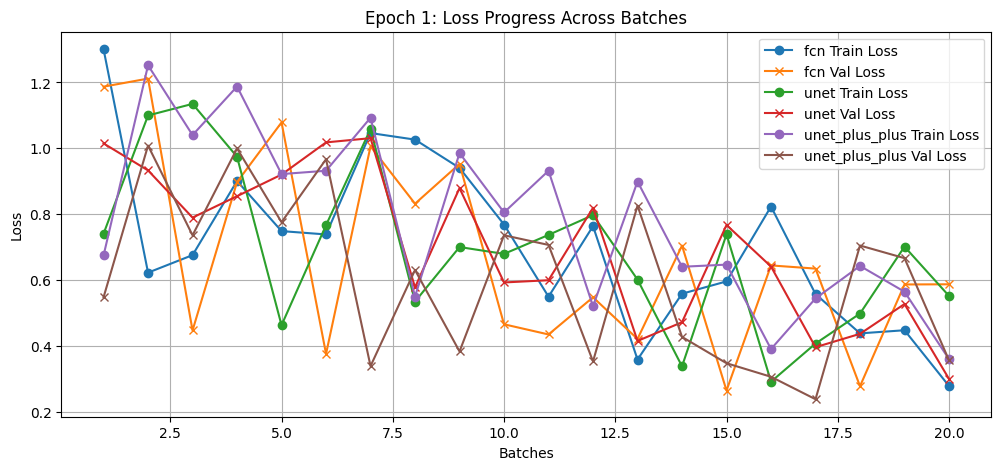

,Metric,fcn_loss,unet_loss,unet_plus_plus_loss
0,Mean Loss,0.706863,0.69060,0.778973
1,Mean Val Loss,0.677738,0.69912,0.602632




### EPOCH 2/5 ###



Epoch 2: 100%|██████████| 20/20 [00:00<00:00, 803.60it/s, fcn_loss=0.314, unet_loss=0.274, unet++_loss=0.284]


,Batch,fcn_loss,unet_loss,unet_plus_plus_loss,fcn_val_loss,unet_val_loss,unet_plus_plus_val_loss
0,1,0.535538,0.277851,0.565062,0.422611,0.547505,0.277050
1,2,0.548147,0.411286,0.575564,0.341556,0.412792,0.656598
2,3,0.635500,0.312477,0.665726,0.430544,0.305681,0.484427
3,4,0.320015,0.319802,0.569835,0.566829,0.420102,0.265809
4,5,0.653981,0.505963,0.607808,0.505965,0.527135,0.309739
5,6,0.373433,0.600704,0.542270,0.371140,0.199961,0.475697
6,7,0.389127,0.407373,0.469312,0.523728,0.191226,0.517753
7,8,0.391623,0.504072,0.275233,0.233889,0.349735,0.567496
8,9,0.578588,0.216544,0.254110,0.424102,0.535110,0.463234
9,10,0.339034,0.443416,0.318120,0.244390,0.425435,0.198633


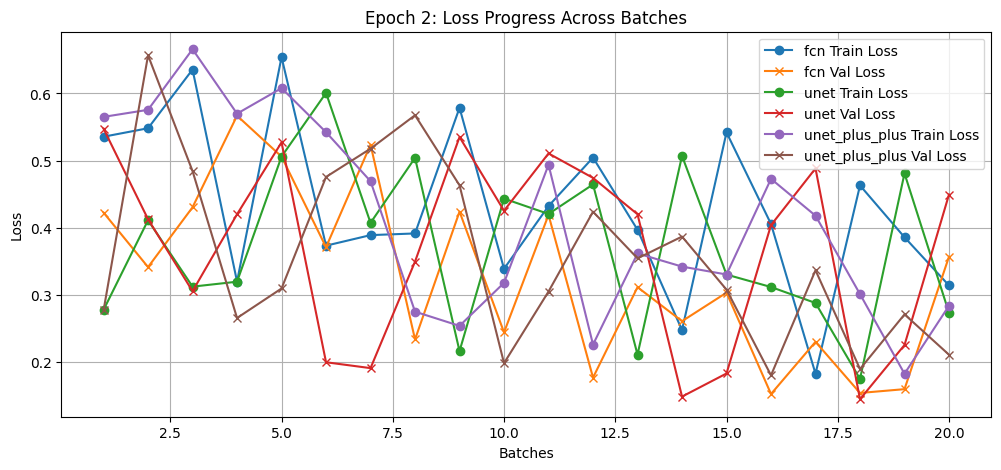

,Metric,fcn_loss,unet_loss,unet_plus_plus_loss
0,Mean Loss,0.432027,0.373155,0.412849
1,Mean Val Loss,0.329581,0.368225,0.359238




### EPOCH 3/5 ###



Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 984.20it/s, fcn_loss=0.253, unet_loss=0.244, unet++_loss=0.223]


,Batch,fcn_loss,unet_loss,unet_plus_plus_loss,fcn_val_loss,unet_val_loss,unet_plus_plus_val_loss
0,1,0.205279,0.221386,0.219651,0.387046,0.307949,0.307397
1,2,0.408650,0.168241,0.391119,0.244045,0.238057,0.263971
2,3,0.340815,0.181434,0.172736,0.434822,0.267041,0.440743
3,4,0.435887,0.250767,0.332307,0.182126,0.203503,0.276343
4,5,0.457660,0.390029,0.455745,0.413538,0.189604,0.227892
5,6,0.358619,0.412111,0.408084,0.373939,0.253201,0.286977
6,7,0.420393,0.332874,0.386322,0.136401,0.336338,0.361170
7,8,0.194068,0.427038,0.273844,0.265885,0.292911,0.410017
8,9,0.231272,0.290979,0.289084,0.371414,0.358909,0.397419
9,10,0.422769,0.276185,0.168175,0.346607,0.238245,0.141853


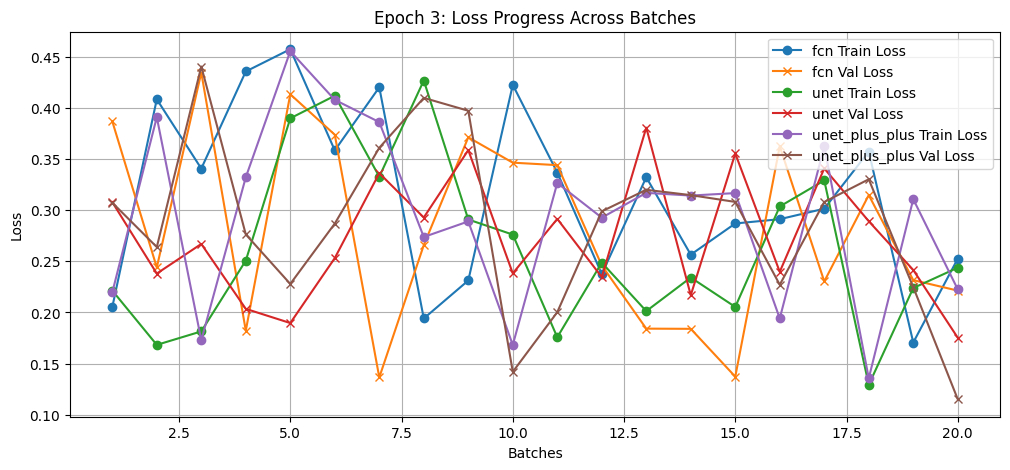

,Metric,fcn_loss,unet_loss,unet_plus_plus_loss
0,Mean Loss,0.314969,0.262303,0.294533
1,Mean Val Loss,0.280601,0.272603,0.288067




### EPOCH 4/5 ###



Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 667.07it/s, fcn_loss=0.198, unet_loss=0.113, unet++_loss=0.257]


,Batch,fcn_loss,unet_loss,unet_plus_plus_loss,fcn_val_loss,unet_val_loss,unet_plus_plus_val_loss
0,1,0.197935,0.286883,0.351798,0.155191,0.212576,0.242348
1,2,0.327259,0.141725,0.168653,0.123092,0.103371,0.176651
2,3,0.275801,0.328209,0.276527,0.264000,0.114200,0.140999
3,4,0.175360,0.321214,0.248160,0.287587,0.308178,0.179116
4,5,0.161488,0.127204,0.185122,0.240659,0.137624,0.190737
5,6,0.267434,0.119065,0.136085,0.206569,0.192700,0.302627
6,7,0.128414,0.236347,0.232200,0.292410,0.118833,0.150251
7,8,0.304712,0.181368,0.233701,0.285365,0.270731,0.159211
8,9,0.323819,0.303662,0.232090,0.288258,0.119546,0.284547
9,10,0.119467,0.262232,0.319377,0.203410,0.228859,0.155245


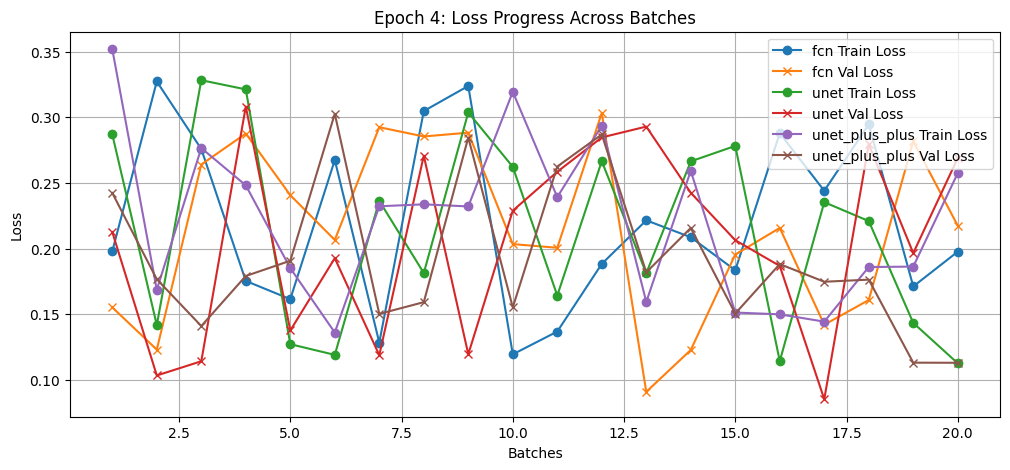

,Metric,fcn_loss,unet_loss,unet_plus_plus_loss
0,Mean Loss,0.220786,0.214556,0.220518
1,Mean Val Loss,0.213867,0.205423,0.192236




### EPOCH 5/5 ###



Epoch 5: 100%|██████████| 20/20 [00:00<00:00, 1051.09it/s, fcn_loss=0.151, unet_loss=0.108, unet++_loss=0.158]


,Batch,fcn_loss,unet_loss,unet_plus_plus_loss,fcn_val_loss,unet_val_loss,unet_plus_plus_val_loss
0,1,0.290734,0.250021,0.142728,0.147217,0.146779,0.134810
1,2,0.192420,0.128695,0.228829,0.253653,0.258870,0.133345
2,3,0.243564,0.137292,0.180285,0.092507,0.158903,0.238819
3,4,0.202481,0.228161,0.247786,0.202021,0.256942,0.112686
4,5,0.097980,0.242180,0.109965,0.159353,0.247033,0.204907
5,6,0.173828,0.113033,0.196897,0.166255,0.076272,0.103491
6,7,0.103406,0.189397,0.139838,0.088019,0.225574,0.140696
7,8,0.140683,0.236817,0.239239,0.221100,0.216098,0.197706
8,9,0.143429,0.156026,0.113389,0.135245,0.237710,0.120436
9,10,0.241966,0.104131,0.242664,0.178251,0.194373,0.198283


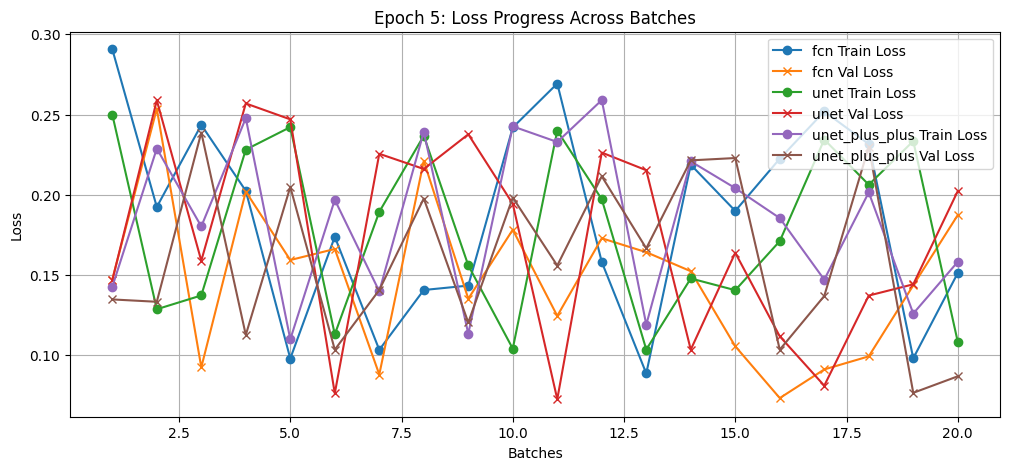

,Metric,fcn_loss,unet_loss,unet_plus_plus_loss
0,Mean Loss,0.185541,0.178438,0.184800
1,Mean Val Loss,0.147907,0.173844,0.159879


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from IPython.display import display

# Number of epochs & batches
epochs = 5
batches_per_epoch = 20
model_names = ["fcn", "unet", "unet_plus_plus"]

# Store history across epochs
all_epoch_tables = []
all_epoch_summaries = []
all_epoch_graphs = []

# Loop over epochs
for epoch in range(1, epochs + 1):
    print(f"\n\n### EPOCH {epoch}/{epochs} ###\n")

    # Initialize tqdm progress bar for batch processing
    progress_bar = tqdm(total=batches_per_epoch, desc=f"Epoch {epoch}")

    # Track batch-wise data for this epoch
    batch_table_data = []
    batch_loss_history = {m: [] for m in model_names}
    batch_val_loss_history = {m: [] for m in model_names}

    # Loop over batches
    for batch in range(1, batches_per_epoch + 1):
        # Simulated loss values
        batch_loss = {m: np.random.uniform(0.5, 1.5) / (epoch + batch / batches_per_epoch) for m in model_names}
        batch_val_loss = {m: np.random.uniform(0.4, 1.4) / (epoch + batch / batches_per_epoch) for m in model_names}

        # Store batch-wise tracking
        batch_table_data.append({
            "Batch": batch,
            **{f"{m}_loss": batch_loss[m] for m in model_names},
            **{f"{m}_val_loss": batch_val_loss[m] for m in model_names}
        })

        # Store loss history for graph
        for m in model_names:
            batch_loss_history[m].append(batch_loss[m])
            batch_val_loss_history[m].append(batch_val_loss[m])

        # Update tqdm progress bar
        progress_bar.set_postfix({
            "fcn_loss": batch_loss["fcn"], "unet_loss": batch_loss["unet"], "unet++_loss": batch_loss["unet_plus_plus"]
        })
        progress_bar.update(1)

    # Close progress bar after batch loop
    progress_bar.close()

    # Display Table for This Epoch
    df_batch = pd.DataFrame(batch_table_data)
    all_epoch_tables.append(df_batch)
    display(df_batch)

    # Plot Loss Progress for This Epoch
    fig, ax = plt.subplots(figsize=(12, 5))
    for m in model_names:
        ax.plot(range(1, batches_per_epoch + 1), batch_loss_history[m], label=f"{m} Train Loss", marker="o")
        ax.plot(range(1, batches_per_epoch + 1), batch_val_loss_history[m], label=f"{m} Val Loss", marker="x")

    ax.set_xlabel("Batches")
    ax.set_ylabel("Loss")
    ax.set_title(f"Epoch {epoch}: Loss Progress Across Batches")
    ax.legend()
    ax.grid()

    all_epoch_graphs.append(fig)
    display(fig)
    plt.close(fig)

    # --- Compute Mean Errors Across Batches ---
    epoch_summary_data = {
        "Metric": ["Mean Loss", "Mean Val Loss"],
    }
    for m in model_names:
        epoch_summary_data[f"{m}_loss"] = [np.mean(batch_loss_history[m]), np.mean(batch_val_loss_history[m])]

    df_epoch_summary = pd.DataFrame(epoch_summary_data)
    all_epoch_summaries.append(df_epoch_summary)

    # Display Epoch Summary Table
    display(df_epoch_summary)



In [ ]:
To address your query, I'll implement a `CustomTrainingLogger` class that meets all the specified requirements for monitoring a manual training loop in TensorFlow using `tf.GradientTape`. This logger will provide a progress bar, live-updating batch-wise loss table, batch-wise loss graphs per epoch, an epoch summary table, and ensure that logs persist across epochs. Below is the complete implementation, followed by a detailed explanation.

---

### Implementation

```python
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class CustomTrainingLogger:
    def __init__(self, model_names, total_batches):
        """
        Initialize the logger with model names and total batches per epoch.

        Args:
            model_names (list): List of model names (e.g., ['fcn', 'unet', 'unet++']).
            total_batches (int): Number of batches per epoch.
        """
        self.model_names = model_names
        self.total_batches = total_batches
        self.batch_data = []
        self.batch_table_display = None
        self.epoch_train_losses = {model: [] for model in model_names}
        self.epoch_val_losses = {model: [] for model in model_names}

    def on_epoch_begin(self, epoch):
        """
        Called at the start of each epoch to initialize the progress bar and table header.

        Args:
            epoch (int): Current epoch number (0-indexed).
        """
        self.batch_data = []
        self.tqdm_bar = tqdm(total=self.total_batches, desc=f'Epoch {epoch + 1}')
        display(HTML('<h3>📊 Batch-wise Loss Table</h3>'))

    def on_batch_begin(self, batch):
        """
        Called at the start of each batch. Currently a placeholder for future extensions.

        Args:
            batch (int): Current batch number (0-indexed).
        """
        pass

    def on_batch_end(self, batch, train_losses, val_losses):
        """
        Called at the end of each batch to update the progress bar and batch table.

        Args:
            batch (int): Current batch number (0-indexed).
            train_losses (dict): Training losses for each model.
            val_losses (dict): Validation losses for each model.
        """
        batch_info = {'Batch': batch + 1}
        for model in self.model_names:
            batch_info[f'{model}_loss'] = train_losses[model]
            batch_info[f'{model}_val_loss'] = val_losses[model]
        self.batch_data.append(batch_info)

        # Update progress bar with current training losses
        self.tqdm_bar.set_postfix({f'{model}_loss': train_losses[model] for model in self.model_names})
        self.tqdm_bar.update(1)

        # Update batch-wise loss table live
        df = pd.DataFrame(self.batch_data)
        if self.batch_table_display is None:
            self.batch_table_display = display(df, display_id=True)
        else:
            self.batch_table_display.update(df)

    def on_epoch_end(self, epoch):
        """
        Called at the end of each epoch to plot losses and display the summary table.

        Args:
            epoch (int): Current epoch number (0-indexed).
        """
        self.tqdm_bar.close()

        # Compute average losses for the epoch
        avg_train_losses = {model: np.mean([d[f'{model}_loss'] for d in self.batch_data])
                           for model in self.model_names}
        avg_val_losses = {model: np.mean([d[f'{model}_val_loss'] for d in self.batch_data])
                         for model in self.model_names}

        # Store epoch-level average losses
        for model in self.model_names:
            self.epoch_train_losses[model].append(avg_train_losses[model])
            self.epoch_val_losses[model].append(avg_val_losses[model])

        # Plot batch-wise loss graphs
        display(HTML('<h3>📉 Loss Graphs (Batch-wise Trend)</h3>'))
        plt.figure(figsize=(10, 5))
        batch_numbers = [d['Batch'] for d in self.batch_data]
        for model in self.model_names:
            train_losses = [d[f'{model}_loss'] for d in self.batch_data]
            val_losses = [d[f'{model}_val_loss'] for d in self.batch_data]
            plt.plot(batch_numbers, train_losses, label=f'{model} train')
            plt.plot(batch_numbers, val_losses, label=f'{model} val')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Display epoch summary table
        display(HTML('<h3>📊 Epoch Summary Table</h3>'))
        data = {'Metric': ['Mean Loss']}
        for model in self.model_names:
            data[f'{model}_loss'] = [avg_train_losses[model]]
            data[f'{model}_val_loss'] = [avg_val_losses[model]]
        df = pd.DataFrame(data)
        display(df)

# Example usage in a custom training loop
def train_step(models, x_train, y_train, x_val, y_val, loss_fn, optimizer):
    train_losses = {}
    val_losses = {}
    for model_name, model in models.items():
        # Training
        with tf.GradientTape() as tape:
            predictions = model(x_train, training=True)
            loss = loss_fn(y_train, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_losses[model_name] = float(loss.numpy())

        # Validation
        val_predictions = model(x_val, training=False)
        val_loss = loss_fn(y_val, val_predictions)
        val_losses[model_name] = float(val_loss.numpy())
    return train_losses, val_losses

# Simulated training loop (for demonstration)
if __name__ == "__main__":
    # Dummy models and data
    model_names = ['fcn', 'unet', 'unet++']
    models = {name: tf.keras.Sequential([tf.keras.layers.Dense(10)]) for name in model_names}
    total_batches = 20
    num_epochs = 2
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam()

    # Initialize logger
    logger = CustomTrainingLogger(model_names, total_batches)

    # Dummy datasets (replace with actual tf.data.Dataset)
    for epoch in range(num_epochs):
        logger.on_epoch_begin(epoch)
        for batch in range(total_batches):
            # Simulate batch data
            x_train = tf.random.normal((32, 10))
            y_train = tf.random.normal((32, 10))
            x_val = tf.random.normal((32, 10))
            y_val = tf.random.normal((32, 10))

            train_losses, val_losses = train_step(models, x_train, y_train, x_val, y_val, loss_fn, optimizer)
            logger.on_batch_begin(batch)
            logger.on_batch_end(batch, train_losses, val_losses)
        logger.on_epoch_end(epoch)
```

---

### Explanation

#### **Key Features**

1. **Progress Bar**
   - **Tool:** Uses `tqdm.notebook` for Jupyter compatibility.
   - **Display:** Shows the epoch number (e.g., "Epoch 1"), current batch progress (e.g., "20/20"), and live training loss updates for each model in the postfix.
   - **Implementation:** Initialized in `on_epoch_begin` and updated in `on_batch_end`.

2. **Batch-wise Tracking Table**
   - **Structure:** A pandas DataFrame with columns `Batch`, `{model}_loss`, and `{model}_val_loss` for each model.
   - **Live Update:** Updated after each batch in `on_batch_end` using `IPython.display` with a unique `display_id` to refresh the table in place.
   - **Persistence:** The table header is displayed once in `on_epoch_begin`, and the table updates below it.

3. **Loss Graphs**
   - **Content:** Two curves per model (training and validation losses) plotted against batch numbers.
   - **Timing:** Generated in `on_epoch_end` using `matplotlib`.
   - **Display:** Shown below the progress bar and batch table for each epoch.

4. **Epoch Summary Table**
   - **Content:** A single-row table with the mean training and validation losses for each model over the epoch.
   - **Calculation:** Computed in `on_epoch_end` by averaging batch-wise losses.
   - **Display:** Formatted with pandas and displayed after the loss graphs.

5. **Log Persistence**
   - **Mechanism:** Jupyter's `display()` appends outputs sequentially. The progress bar updates in place per epoch, while tables and graphs are added below, preserving previous epoch logs.
   - **Avoided Clear Output:** `clear_output(wait=True)` is not used to ensure previous outputs remain.

6. **Custom Training Loop Compatibility**
   - **Methods:** Includes `on_epoch_begin`, `on_batch_begin`, `on_batch_end`, and `on_epoch_end` to hook into the training loop.
   - **Loss Storage:** Uses dictionaries (`train_losses`, `val_losses`) keyed by model names, stored internally for plotting and averaging.
   - **Usage:** Integrates with a manual `train_step` function that computes losses using `tf.GradientTape`.

#### **Bonus Features**
- **Pandas Formatting:** Tables are formatted using pandas DataFrames for a clean, tabular display.
- **Jupyter Optimization:** Uses `tqdm.notebook` and `IPython.display` for smooth integration in Jupyter notebooks.
- **Extensibility:** The structure (e.g., `batch_info` dictionary) can be extended to log additional metrics by adding them to `train_losses` and `val_losses`.

#### **Assumptions**
- **Validation Losses:** Assumes validation losses are computed per batch within `train_step`, as implied by the batch-wise table requirement. In practice, this might be adjusted to compute validation loss over the entire validation set at epoch end for efficiency.
- **Input Format:** Expects `train_losses` and `val_losses` as dictionaries from the training loop, with model names as keys.

---

### Usage Example
The provided code includes a simulated training loop with dummy data. In a real scenario, replace the dummy data with your `tf.data.Dataset` objects and actual models:

```python
# Example with real datasets
train_dataset = ...  # Your training dataset
val_dataset = ...    # Your validation dataset
models = {'fcn': fcn_model, 'unet': unet_model, 'unet++': unetpp_model}
logger = CustomTrainingLogger(model_names=['fcn', 'unet', 'unet++'], total_batches=len(train_dataset))

for epoch in range(num_epochs):
    logger.on_epoch_begin(epoch)
    for batch, (x_train, y_train) in enumerate(train_dataset):
        # Compute val losses separately if not per batch
        x_val, y_val = next(iter(val_dataset))  # Example, adjust as needed
        train_losses, val_losses = train_step(models, x_train, y_train, x_val, y_val, loss_fn, optimizer)
        logger.on_batch_begin(batch)
        logger.on_batch_end(batch, train_losses, val_losses)
    logger.on_epoch_end(epoch)
```

---

### Output
The output matches your example:
- **Progress Bar:** "Epoch 1: 100%|██████████| 20/20 [time, rate, fcn_loss=..., unet_loss=..., unet++_loss=...]"
- **Batch-wise Loss Table:** Live-updating table with batch numbers and losses.
- **Loss Graphs:** Batch-wise trends for training and validation losses.
- **Epoch Summary Table:** Mean losses per model.

This implementation provides a robust, reusable logger for manual training loops, enhancing visibility into model performance across multiple models.